In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

2023-04-06 20:15:39.627772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(train_raw, val_raw, test_raw), ds_info = tfds.load(
                                          name='cifar10',
                                          split=['train[:90%]', 
                                                'train[90%:]', 
                                                'test'], 
                                          shuffle_files=True,
                                          as_supervised=True,
                                          with_info=True
                                          )

In [3]:
# Get number of classes
num_classes = ds_info.features['label'].num_classes
print('Number of classes:', num_classes)

# Get split sizes (aka cardinality)
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print('Number of training samples:', num_train_examples)
print('Number of validation samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of classes: 10
Number of training samples: 45000
Number of validation samples: 5000
Number of test samples: 10000


In [4]:
def get_value_counts(ds):
  label_list = []
  for images, labels in ds: 
    label_list.append(labels.numpy()) # Convert tensor to numpy array
  label_counts = pd.Series(label_list).value_counts(sort=True)

  print(label_counts)

In [5]:
# Obtain name for label integer
get_label_name = ds_info.features['label'].int2str

def view_single_image(ds):
  image, label = next(iter(ds)) # Get next image (random)
  print('Image shape: ', image.shape) # Get shape of image
  plt.imshow(image)
  _ = plt.title(get_label_name(label))

2023-04-06 20:15:45.833140: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


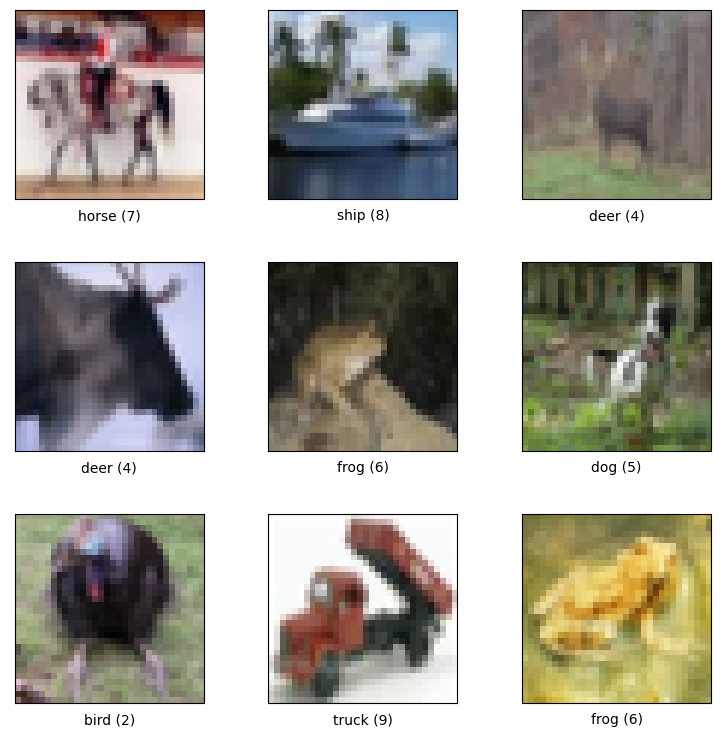

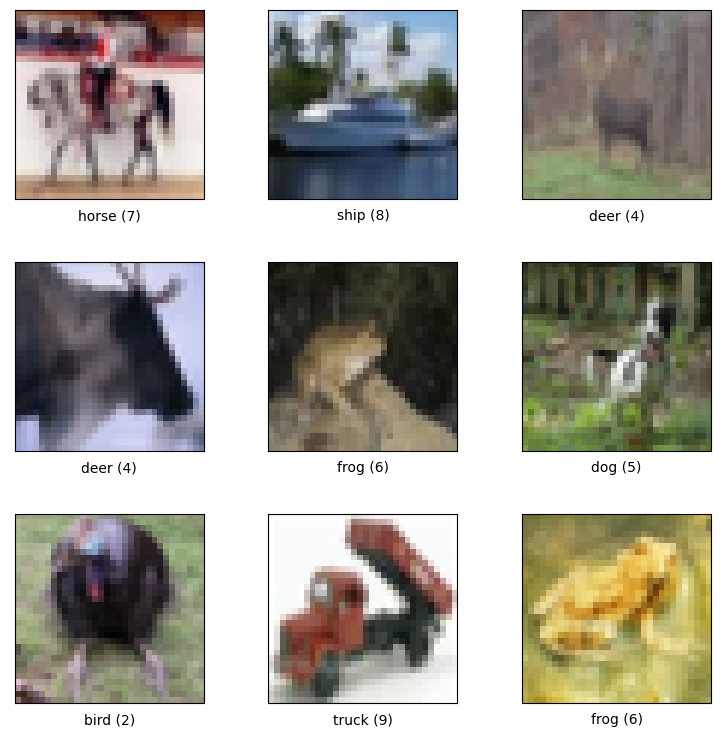

In [6]:
tfds.show_examples(train_raw, ds_info, image_key='image')

In [7]:
IMG_SIZE = 224

train_ds = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
val_ds = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
test_ds = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [9]:
data_augmentation = keras.Sequential(
                [layers.RandomFlip('horizontal'), 
                layers.RandomRotation(factor=(-0.025, 0.025)),
                layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
                layers.RandomContrast(factor=0.1),
                ])

2023-04-06 20:15:48.976498: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


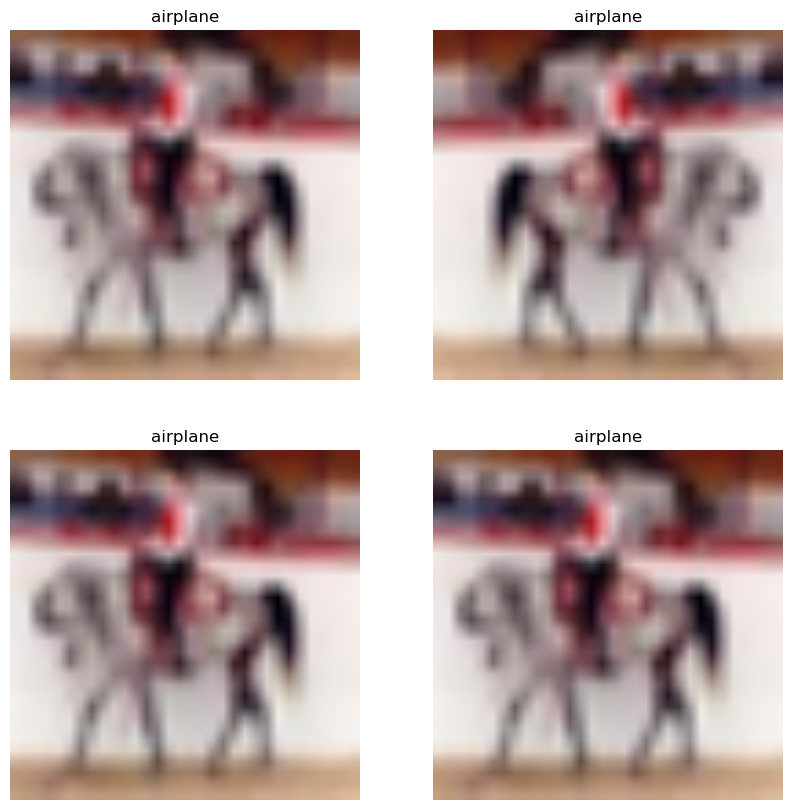

In [10]:
for image, label in train_ds.take(1): # Iterate and get set of image and label from train_ds generator
    plt.figure(figsize=(10, 10))
    for i in range(4):  # Display augmented images in 2x2 grid
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype('uint8')) # Retrieve raw pixel value
        plt.title(get_label_name(int(label[0]))) # Get corresponding label
        plt.axis('off')

In [11]:
BATCH_SIZE = 32

train_ds = train_ds.batch(batch_size=BATCH_SIZE, 
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size=BATCH_SIZE, 
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.batch(batch_size=BATCH_SIZE, 
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [12]:
base_model = keras.applications.ResNet50V2(
                        include_top=False, # Exclude ImageNet classifier at the top
                        weights='imagenet',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)
                        )

94668760/94668760 [==============================] - 3s 0us/step


In [13]:
# Freeze base_model
base_model.trainable = False

In [14]:
# Setup inputs based on input image shape
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [15]:
x = data_augmentation(inputs)

In [16]:
# Apply specific pre-processing function for ResNet v2
x = keras.applications.resnet_v2.preprocess_input(x)

In [17]:
# Keep base model batch normalization layers in inference mode (instead of training mode)
x = base_model(x, training=False)

In [18]:
# Rebuild top layers
x = layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = layers.BatchNormalization()(x) # Introduce batch norm
x = layers.Dropout(0.2)(x)  # Regularize with dropout

# Flattening to final layer - Dense classifier with 37 units (multi-class classification)
outputs = layers.Dense(num_classes, activation='softmax')(x)

In [19]:
# Instantiate final Keras model with updated inputs and outputs
model = keras.Model(inputs, outputs)

In [20]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
              )

In [21]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        patience=5, 
                                        restore_best_weights=True)

In [22]:
EPOCHS = 25

history = model.fit(train_ds, 
                    epochs=EPOCHS, 
                    validation_data=val_ds, 
                    verbose=1,
                    callbacks =[earlystopping])

Epoch 1/25
1406/1406 [==============================] - 148s 74ms/step - loss: 0.5203 - categorical_accuracy: 0.8283 - val_loss: 0.3745 - val_categorical_accuracy: 0.8772
Epoch 2/25
1406/1406 [==============================] - 78s 55ms/step - loss: 0.3804 - categorical_accuracy: 0.8736 - val_loss: 0.3579 - val_categorical_accuracy: 0.8842
Epoch 3/25
1406/1406 [==============================] - 78s 56ms/step - loss: 0.3499 - categorical_accuracy: 0.8822 - val_loss: 0.3598 - val_categorical_accuracy: 0.8876
Epoch 4/25
1406/1406 [==============================] - 106s 75ms/step - loss: 0.3381 - categorical_accuracy: 0.8860 - val_loss: 0.3567 - val_categorical_accuracy: 0.8886
Epoch 5/25
1406/1406 [==============================] - 116s 83ms/step - loss: 0.3285 - categorical_accuracy: 0.8898 - val_loss: 0.3492 - val_categorical_accuracy: 0.8858
Epoch 6/25
1406/1406 [==============================] - 80s 57ms/step - loss: 0.3180 - categorical_accuracy: 0.8914 - val_loss: 0.3581 - val_catego

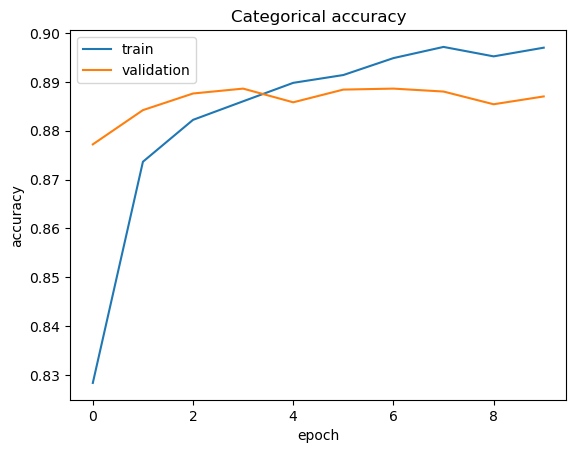

In [23]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

In [24]:
result = model.evaluate(test_ds)


312/312 [==============================] - 13s 42ms/step - loss: 0.3808 - categorical_accuracy: 0.8793


In [25]:
for layer in model.layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [26]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Set a very low learning rate
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
              )

In [27]:
EPOCHS = 5

history_2 = model.fit(train_ds, 
                      epochs=EPOCHS, 
                      validation_data=val_ds, 
                      verbose=1,
                      callbacks =[earlystopping])

result_2 = model.evaluate(test_ds)

Epoch 1/5
1406/1406 [==============================] - 451s 304ms/step - loss: 0.2500 - categorical_accuracy: 0.9201 - val_loss: 0.1917 - val_categorical_accuracy: 0.9395
Epoch 2/5
1406/1406 [==============================] - 429s 305ms/step - loss: 0.0880 - categorical_accuracy: 0.9703 - val_loss: 0.1850 - val_categorical_accuracy: 0.9453
Epoch 3/5
1406/1406 [==============================] - 429s 305ms/step - loss: 0.0395 - categorical_accuracy: 0.9862 - val_loss: 0.2034 - val_categorical_accuracy: 0.9433
Epoch 4/5
1406/1406 [==============================] - 432s 308ms/step - loss: 0.0278 - categorical_accuracy: 0.9907 - val_loss: 0.1956 - val_categorical_accuracy: 0.9475
Epoch 5/5
312/312 [==============================] - 13s 40ms/step - loss: 0.2089 - categorical_accuracy: 0.9450


In [28]:
preds = model.predict(test_ds)

312/312 [==============================] - 13s 41ms/step
